In [3]:
!git clone https://github.com/sithu31296/semantic-segmentation
%pip install -U gdown
%pip install -e .
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

fatal: destination path 'semantic-segmentation' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/paolo/Downloads/magistrale/1%20anno/visiope/visiope/models
ERROR: file:///home/paolo/Downloads/magistrale/1%20anno/visiope/visiope/models does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import torch
import numpy as np
from torchvision import io
from torchvision import transforms as T
from PIL import Image
import pickle
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, Dataset, random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%cd semantic-segmentation

/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/models/semantic-segmentation


In [6]:
help(tuple)

Help on class tuple in module builtins:

class tuple(object)
 |  tuple(iterable=(), /)
 |  
 |  Built-in immutable sequence.
 |  
 |  If no argument is given, the constructor returns an empty tuple.
 |  If iterable is specified the tuple is initialized from iterable's items.
 |  
 |  If the argument is a tuple, the return value is the same object.
 |  
 |  Built-in subclasses:
 |      asyncgen_hooks
 |      UnraisableHookArgs
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __getnewargs__(self, /)
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __

In [12]:
import torch
from torch import nn, Tensor
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from itertools import chain
from math import ceil
from base_model import BaseModel

class DecoderBottleneck(nn.Module):
    def __init__(self, inchannels):
        super(DecoderBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inchannels, inchannels//4, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(inchannels//4)
        self.conv2 = nn.ConvTranspose2d(inchannels//4, inchannels//4, kernel_size=2, stride=2, bias=False)
        self.bn2 = nn.BatchNorm2d(inchannels//4)
        self.conv3 = nn.Conv2d(inchannels//4, inchannels//2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(inchannels//2)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
                nn.ConvTranspose2d(inchannels, inchannels//2, kernel_size=2, stride=2, bias=False),
                nn.BatchNorm2d(inchannels//2))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class LastBottleneck(nn.Module):
    def __init__(self, inchannels):
        super(LastBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inchannels, inchannels//4, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(inchannels//4)
        self.conv2 = nn.Conv2d(inchannels//4, inchannels//4, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inchannels//4)
        self.conv3 = nn.Conv2d(inchannels//4, inchannels//4, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(inchannels//4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
                nn.Conv2d(inchannels, inchannels//4, kernel_size=1, bias=False),
                nn.BatchNorm2d(inchannels//4))
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResDecode(BaseModel):
    def __init__(self, model_name: str = '50'):
        resnet50 = torchvision.models.resnet50()

        # Decoder
        resnet50_untrained = models.resnet50(pretrained=False)
        resnet50_blocks = list(resnet50_untrained.children())[4:-2][::-1]
        decoder = []
        channels = (2048, 1024, 512)
        for i, block in enumerate(resnet50_blocks[:-1]):
            new_block = list(block.children())[::-1][:-1]
            decoder.append(nn.Sequential(*new_block, DecoderBottleneck(channels[i])))
        new_block = list(resnet50_blocks[-1].children())[::-1][:-1]
        decoder.append(nn.Sequential(*new_block, LastBottleneck(256)))

        self.decoder = nn.Sequential(*decoder)
        self.last_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, bias=False),
            nn.Conv2d(64, num_classes, kernel_size=3, stride=1, padding=1)
        )
        
    def forward(self, x: Tensor) -> Tensor:
        inputsize = x.size()

        # Decoder
        x = self.decoder(x)
        h_diff = ceil((x.size()[2] - indices.size()[2]) / 2)
        w_diff = ceil((x.size()[3] - indices.size()[3]) / 2)
        if indices.size()[2] % 2 == 1:
            x = x[:, :, h_diff:x.size()[2]-(h_diff-1), w_diff: x.size()[3]-(w_diff-1)]
        else:
            x = x[:, :, h_diff:x.size()[2]-h_diff, w_diff: x.size()[3]-w_diff]

        x = F.max_unpool2d(x, indices, kernel_size=2, stride=2)
        x = self.last_conv(x)
        
        if inputsize != x.size():
            h_diff = (x.size()[2] - inputsize[2]) // 2
            w_diff = (x.size()[3] - inputsize[3]) // 2
            x = x[:, :, h_diff:x.size()[2]-h_diff, w_diff: x.size()[3]-w_diff]
            if h_diff % 2 != 0: x = x[:, :, :-1, :]
            if w_diff % 2 != 0: x = x[:, :, :, :-1]

        return x    



if __name__ == '__main__':
    module = nn.Module()
    model = ResDecode(module)
    x = torch.zeros(1, 3, 224, 224)
    outs = model(x)
    for y in outs:
        print(y.shape)
        

AttributeError: cannot assign module before Module.__init__() call

In [3]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from semseg.models.base import BaseModel
from semseg.models.heads import SegFormerHead
from resDecode import ResDecode


class SegFormerpp(BaseModel):
    def __init__(self, backbone: str = 'MiT-B0', num_classes: int = 19, head: str = 'B0') -> None:
        super().__init__(backbone, num_classes)
        self.num_classes = num_classes
        self.head = head
        self.decode = SegFormerHead(self.backbone.channels, 256 if 'B0' in backbone or 'B1' in backbone else 768, 3)
        self.decode_head = ResDecode(head)

        self.apply(self._init_weights)

    def forward(self, x: Tensor) -> Tensor:
        y = self.backbone(x)
        print(len(y))
        y = self.decode(y)
        y = F.interpolate(y, size=x.shape[2:], mode='bilinear', align_corners=False)
        y = self.decode_head(y)
        return y


if __name__ == '__main__':
    model = SegFormerpp('MiT-B0')
    # model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b0.ade.pth', map_location='cpu'))
    x = torch.zeros(1, 3, 512, 512)
    y = model(x)
    print(y.shape)

NameError: name 'torchvision' is not defined

In [3]:
#from semseg.models import *
#from segFormerpp import SegFormerpp

model = eval('SegFormerpp')(
    backbone='MiT-B3',
    num_classes=150
)

try:
    model.load_state_dict(torch.load('checkpointcheckpoints/pretrained/segformer/segformer.b3.ade.pth'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()
model.to(device)
print('Loaded Model')

Download a pretrained model's weights from the result table.
Loaded Model


In [8]:
model.eval()

SegFormer(
  (backbone): MiT(
    (patch_embed1): PatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): PatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): PatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): PatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64, out_features=64, bias=True)
          (kv): 

In [4]:
%cd ../../dataloader/
from load import Ai4MarsData
%cd ../models/semantic-segmentation

/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/dataloader
/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/models/semantic-segmentation


In [5]:
import numpy as np
import torch 
from torch.utils.data import DataLoader, Dataset, random_split



#This class rappresents the dataset 
class Ai4MarsData(Dataset):
    #X tensor (torch) -> images
    #y tensor (torch) -> labels

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        image = self.X[index]
        label = self.y[index]

        if self.transform:
            image = self.transform(image)

        return image, label
    
    #this function return 3 dataloader (train,test,validation) splitted from self 
    #percentage -> give percentage of train size, the rest of percentage is given divided the residual part
    #sizeBatch -> determine the size of batch
    def splitLoader(self,percentage,sizeBatch):
        dataset = self
        ratio = percentage/100

        #setup variables
        d_size = len(self)
        train_size = int(ratio*d_size)
        test_size = int((d_size - train_size)/2)
        validation_size = test_size

        #split
        train_dataset, test_dataset, validation_dataset = random_split(dataset,[train_size,test_size,validation_size])
        
        #create other loaders
        train_loader = DataLoader(train_dataset,batch_size=sizeBatch)
        test_loader = DataLoader(test_dataset,batch_size=sizeBatch)
        validation_loader = DataLoader(validation_dataset,batch_size=sizeBatch)
        '''       
        for images, labels in train_loader:
            print(images.shape)
            images = images.permute(0,3,1,2).to(device)
      
        for images, labels in test_loader:
            images = images.permute(0,3,1,2).to(device)
            
        for images, labels in validation_loader:
            images = images.permute(0,3,1,2).to(device)
        '''
            
        return train_loader,test_loader,validation_loader


In [ ]:
!git clone https://github.com/airoprojects/visiope
with open('/content/drive/MyDrive/Dataset/data_loader.pkl', 'rb') as f:
    data_loader = pickle.load(f)


items = data_loader['dataloader'].dataset.__getitem__(1)


print(items[0].shape)


plt.imshow(items[0])
plt.show()

In [6]:
#local
with open('../../dataloader/data_loader.pkl', 'rb') as f:
    data_loader = pickle.load(f)


items = data_loader['dataloader'].dataset.__getitem__(1)

train_loader, test_loader, validation_loader = data_loader['dataloader'].dataset.splitLoader(80,1)


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

def show_image(imgs):
    imgs = imgs.permute(2,0,1)
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

'''  
  print(img.device)
  print(img.shape)
  if (img.device != 'cpu'):
    img.to('cpu')
    print('test')
  print(img.device)
  plt.imshow(img)
  plt.show()
'''

"  \n  print(img.device)\n  print(img.shape)\n  if (img.device != 'cpu'):\n    img.to('cpu')\n    print('test')\n  print(img.device)\n  plt.imshow(img)\n  plt.show()\n"

In [8]:
%cd ../../loss/
from trainer_module import trainer
%cd ../models/semantic-segmentation

/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/loss
/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/models/semantic-segmentation


In [19]:
for i, data in enumerate(training_set):
        inputs, labels = data
        print(inputs.shape)
        inputs = inputs.permute(0,3,1,2).to(device)
        # Zero your gradients for every batch!+
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1, 224, 224, 3])
torch.Size([1,

In [9]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
training_set = train_loader
validation_set = test_loader

parameters = {
    'model' : model,
    'loss' : loss_fn,
    'optimizer' : optimizer,
    'training' : training_set,
    'validation' : validation_set,
    'device' : device
}
trainer(parameters)

<class 'list'>


RuntimeError: input and target batch or spatial sizes don't match: target [1, 224, 224], input [1, 150, 56, 56]

/tmp/ipykernel_25473/1641144638.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)


7.067660808563232


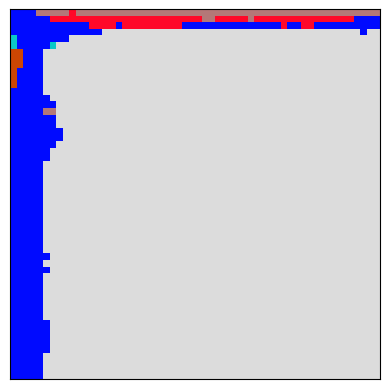

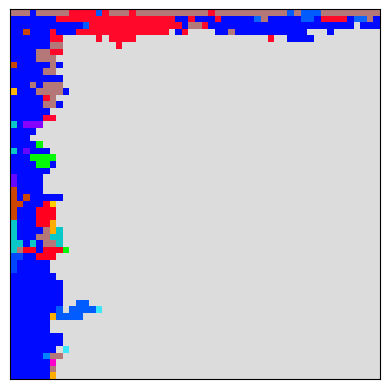

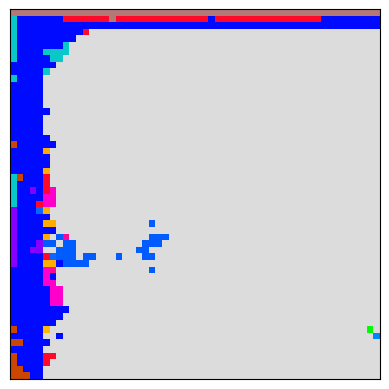

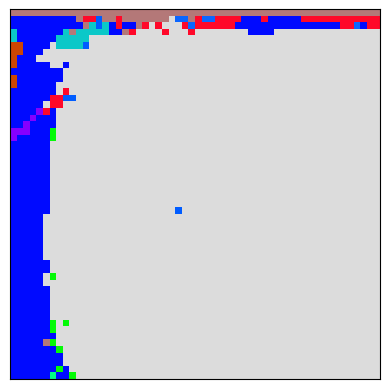

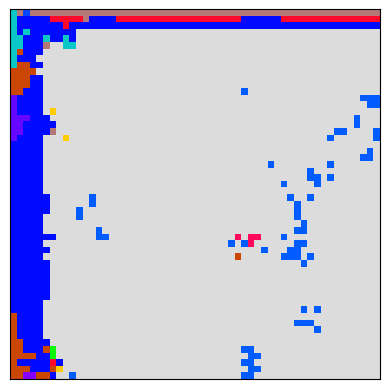

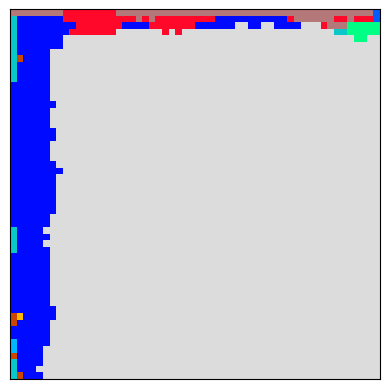

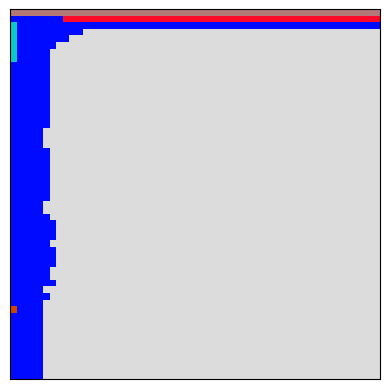

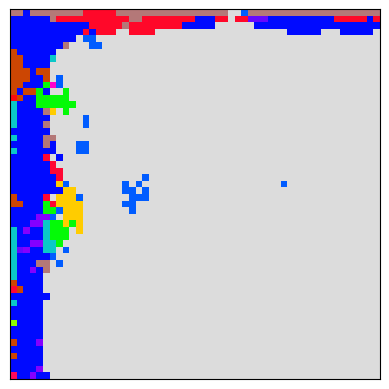

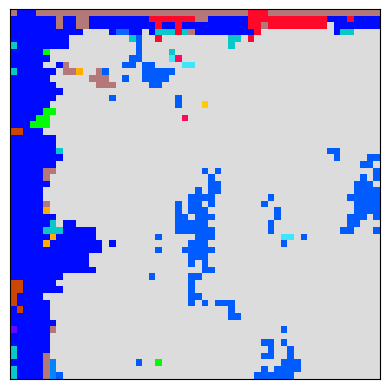

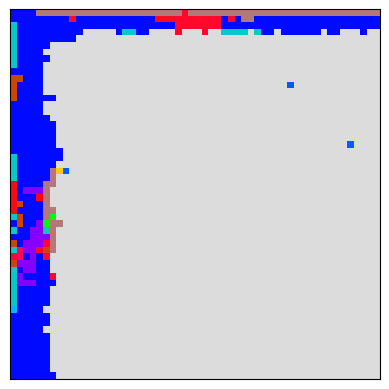

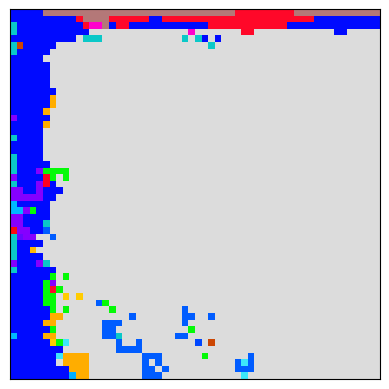

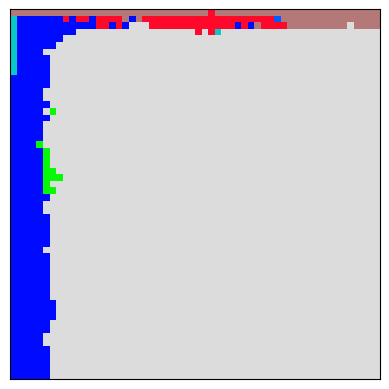

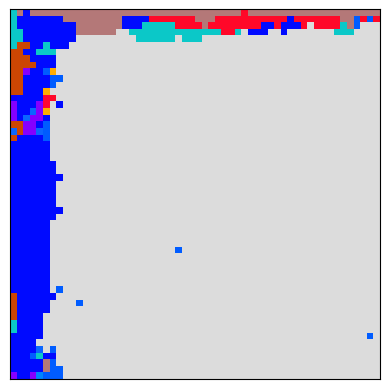

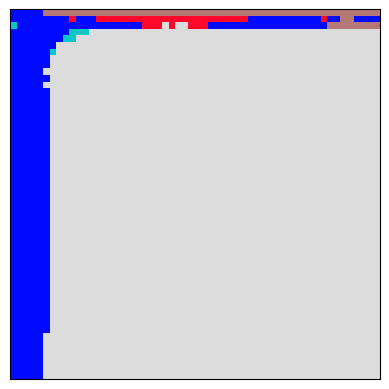

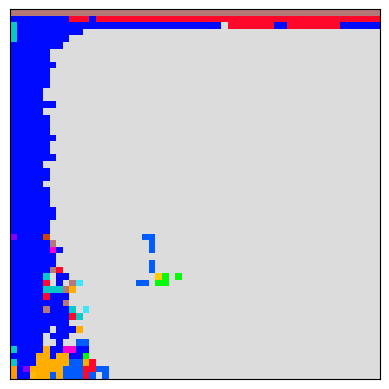

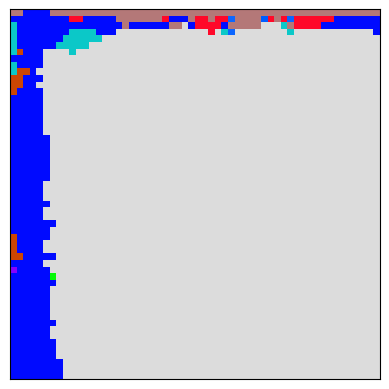

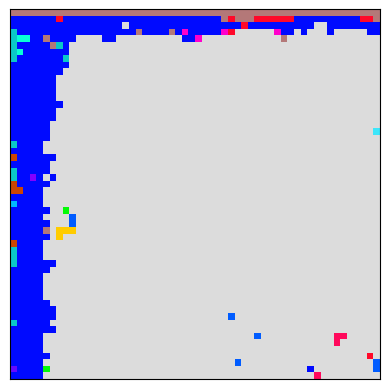

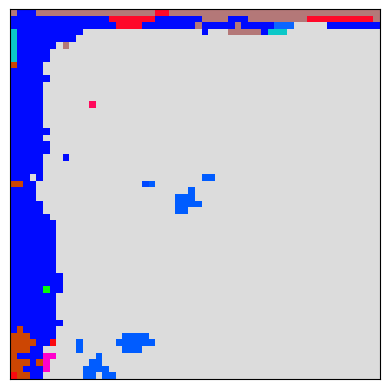

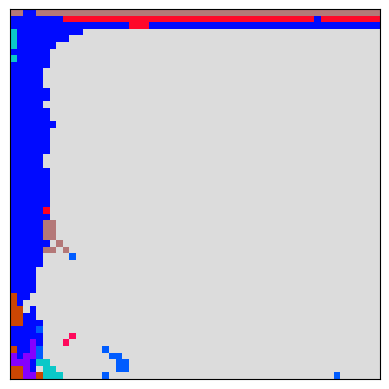

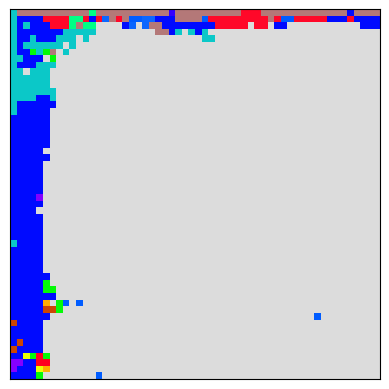

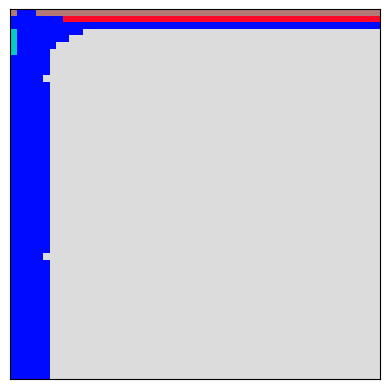

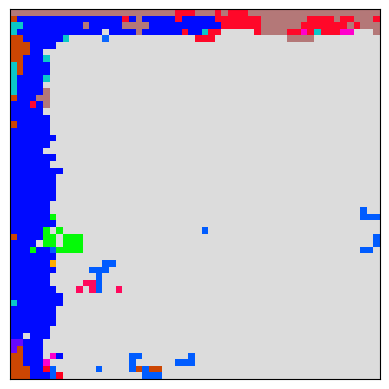

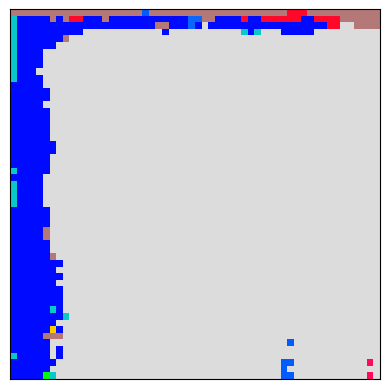

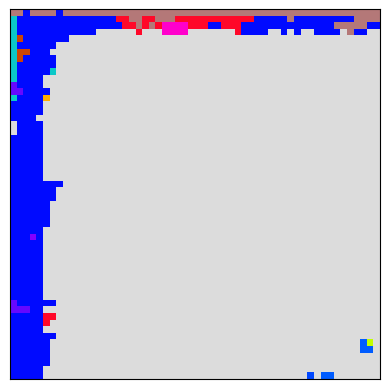

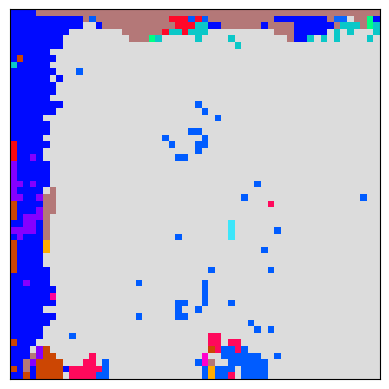

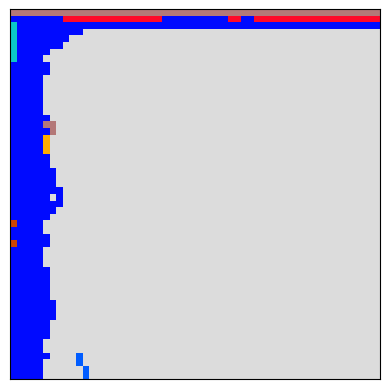

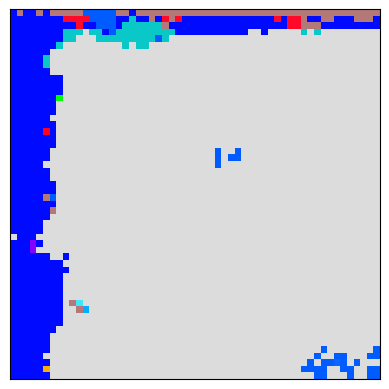

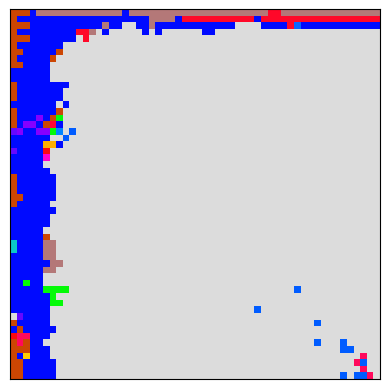

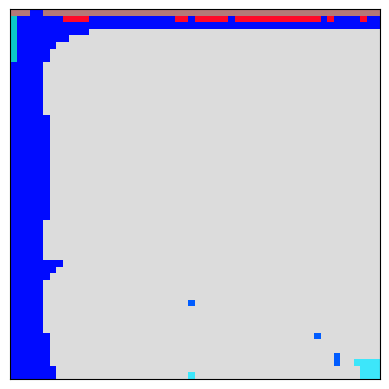

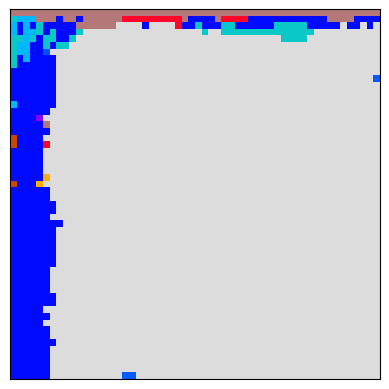

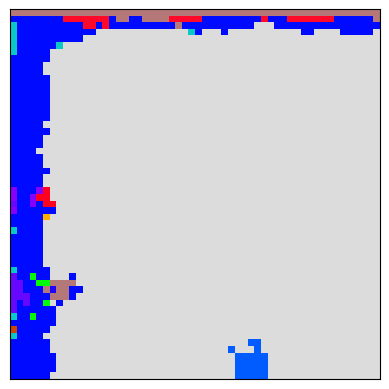

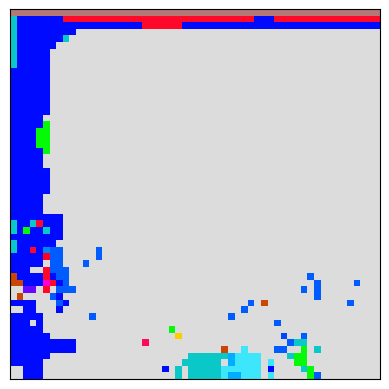

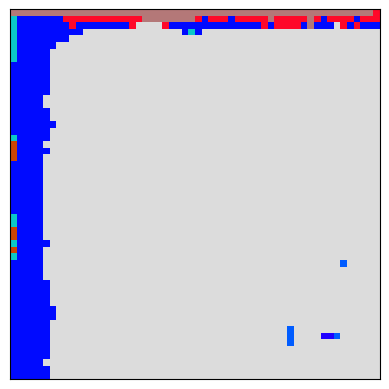

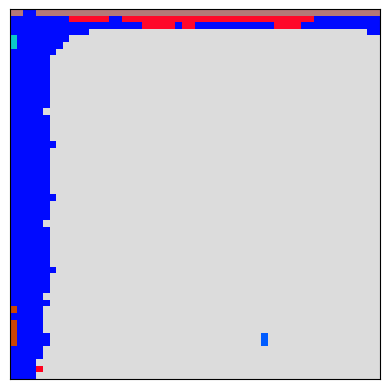

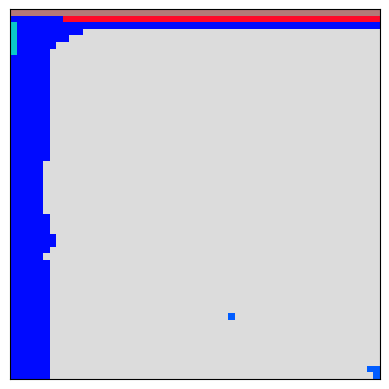

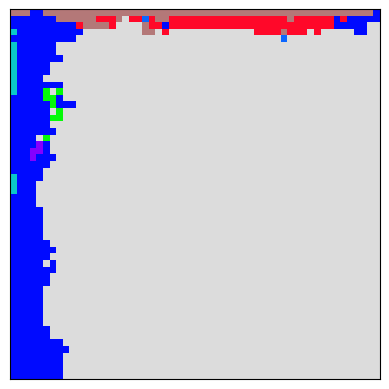

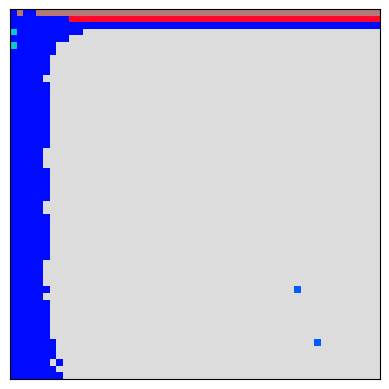

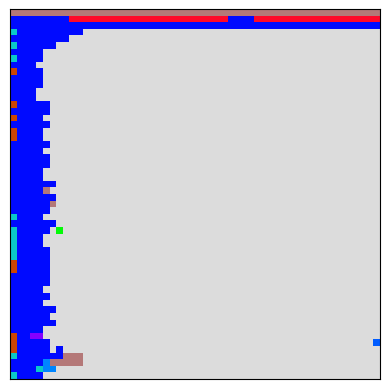

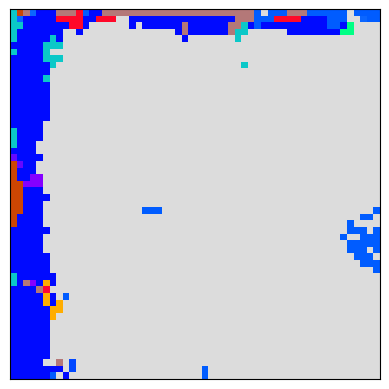

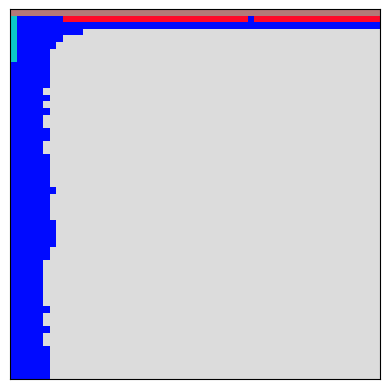

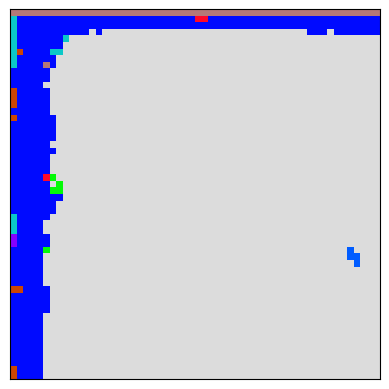

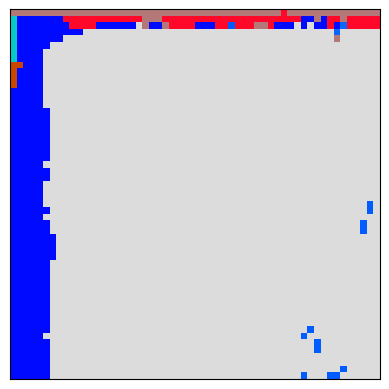

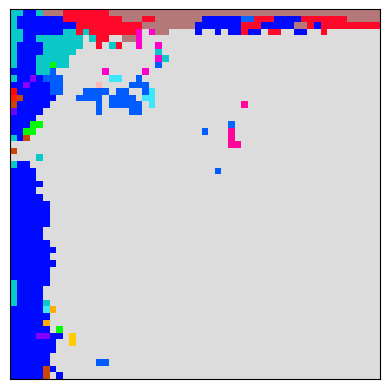

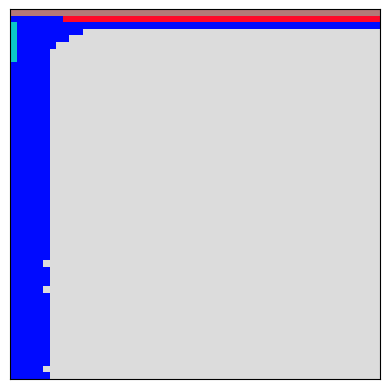

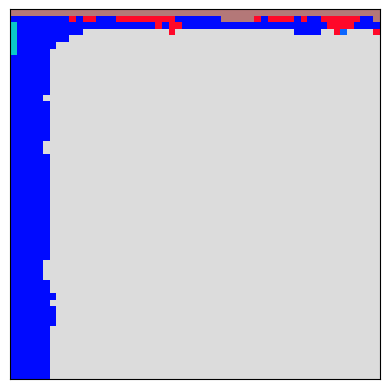

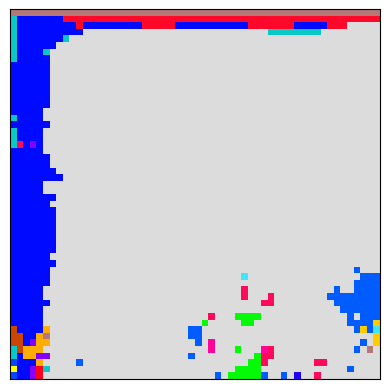

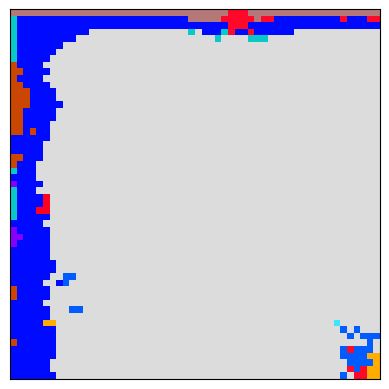

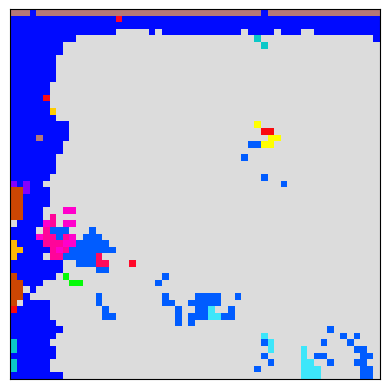

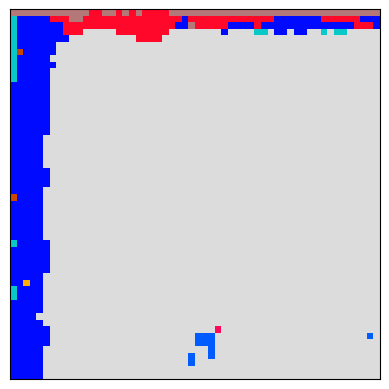

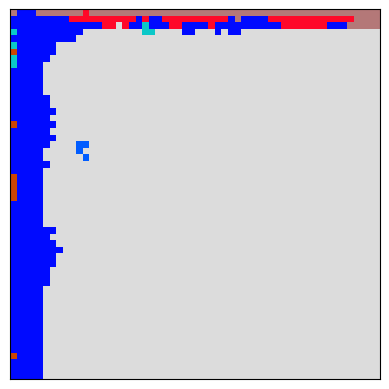

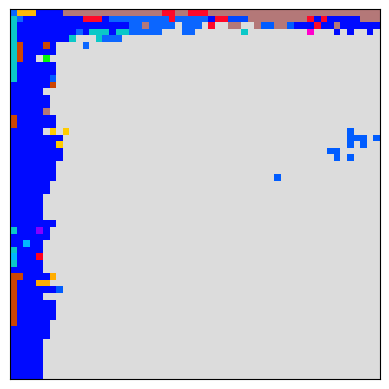

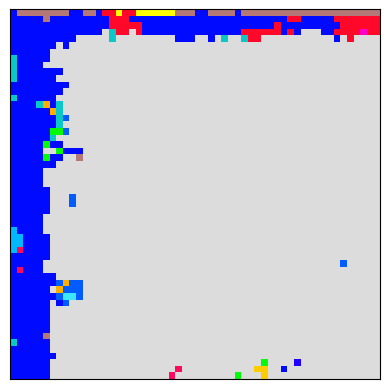

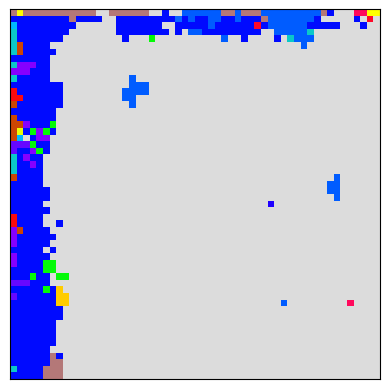

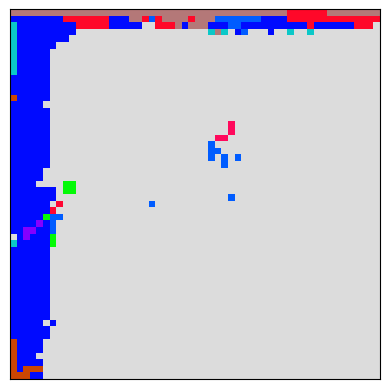

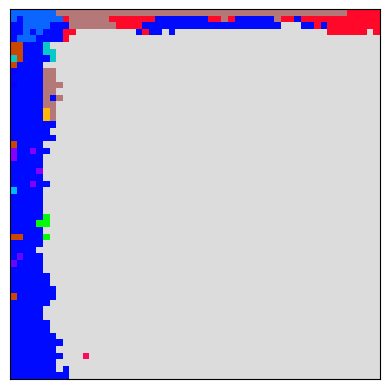

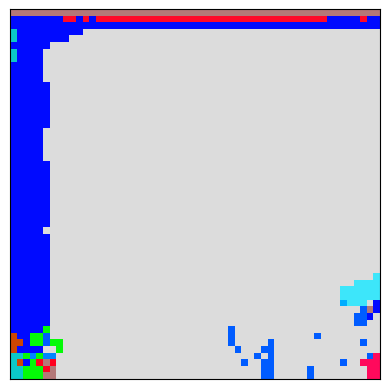

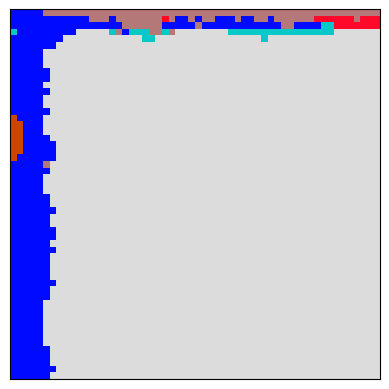

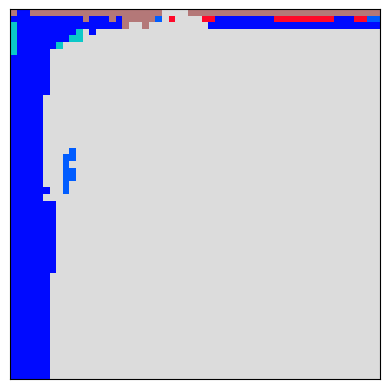

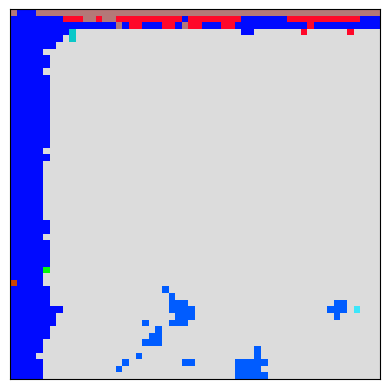

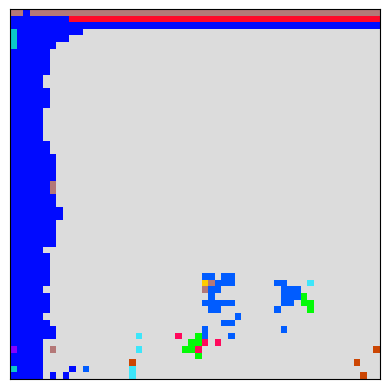

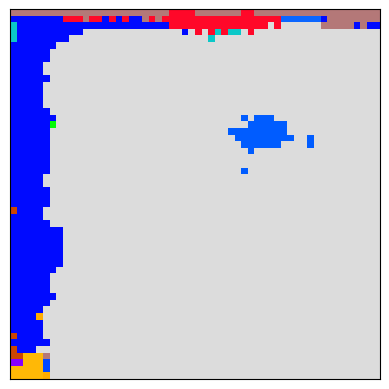

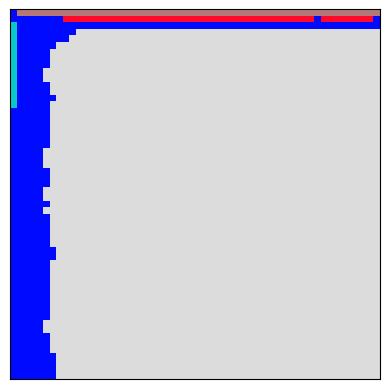

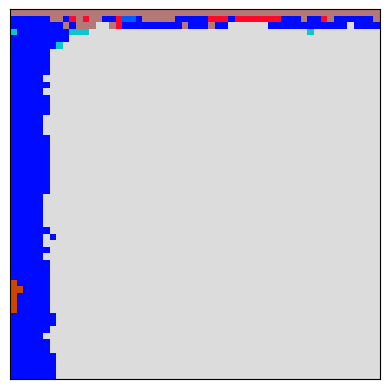

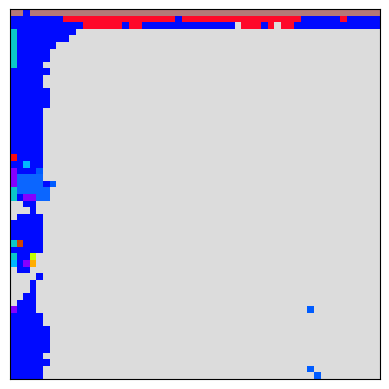

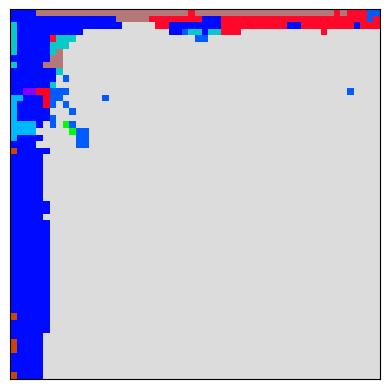

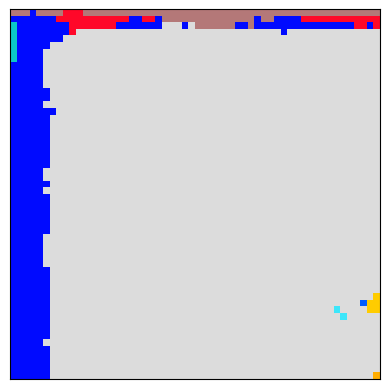

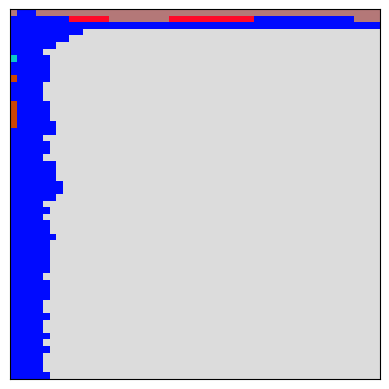

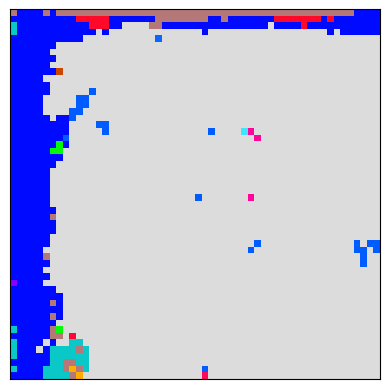

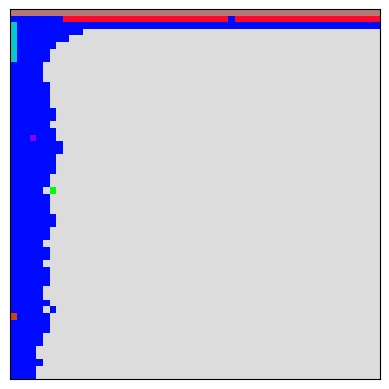

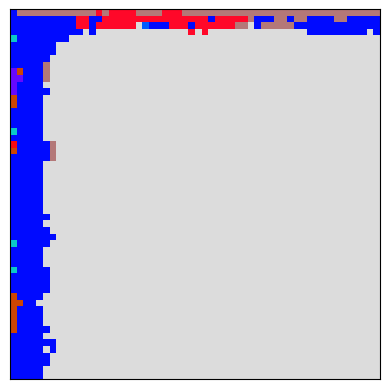

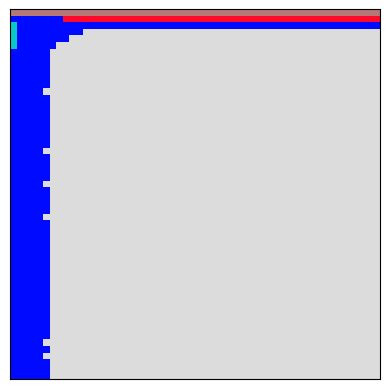

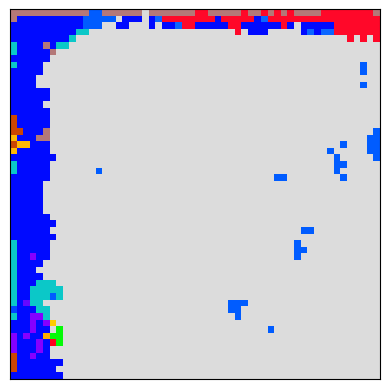

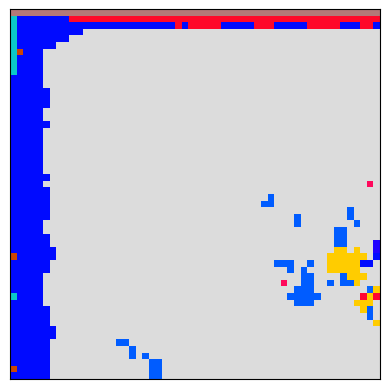

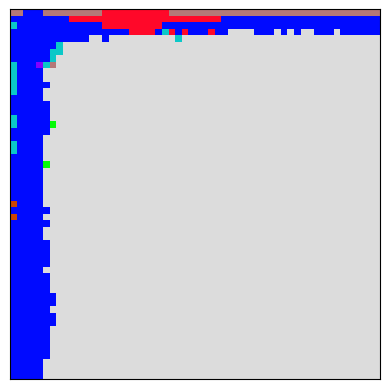

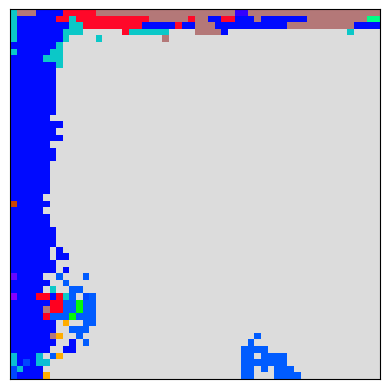

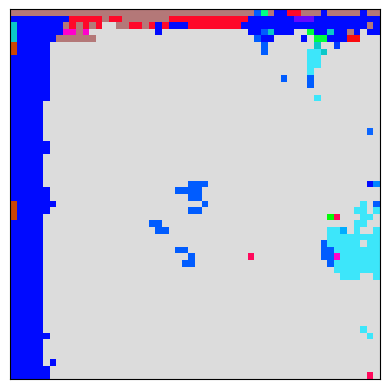

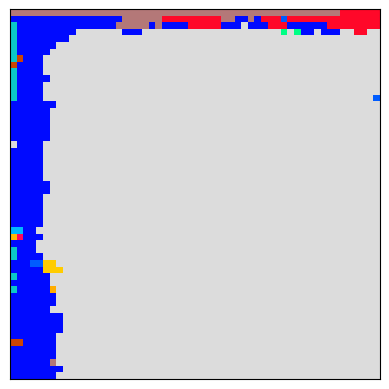

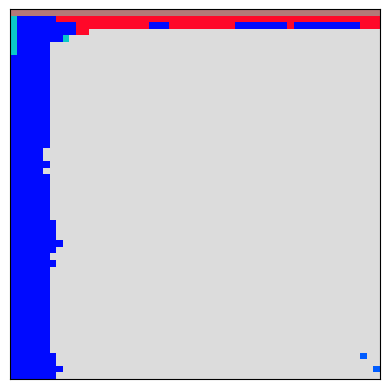

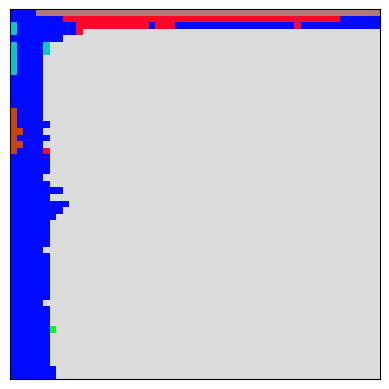

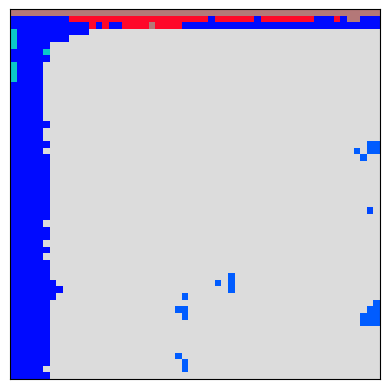

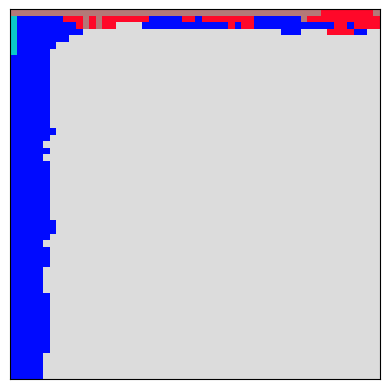

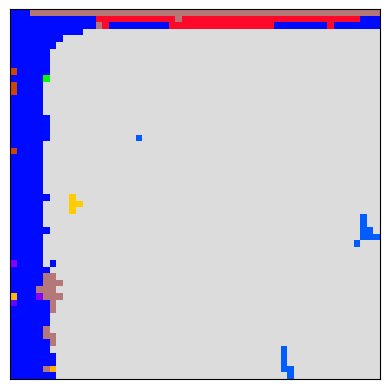

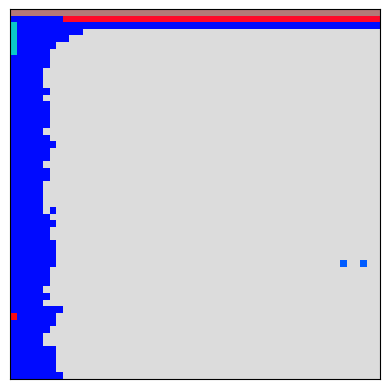

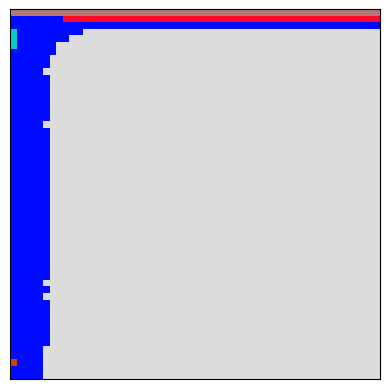

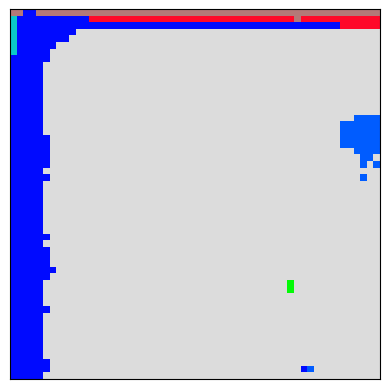

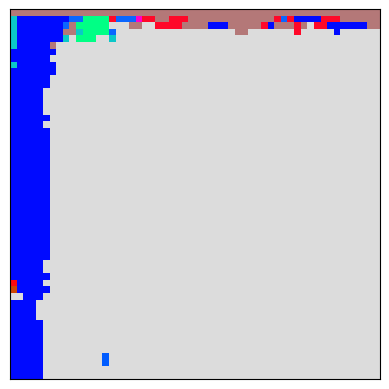

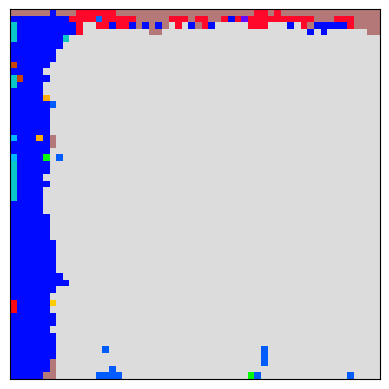

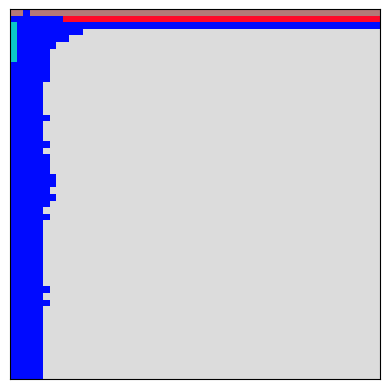

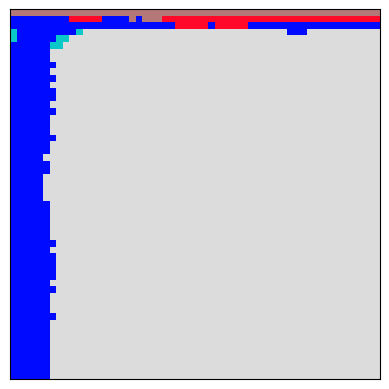

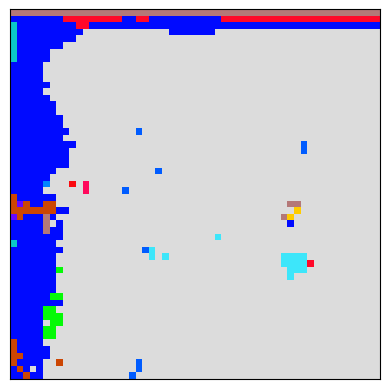

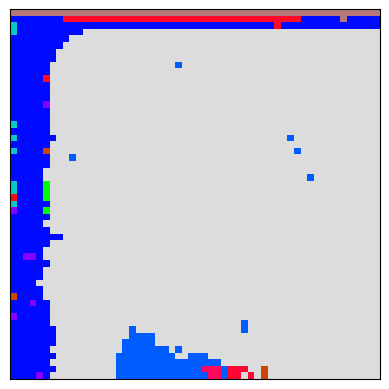

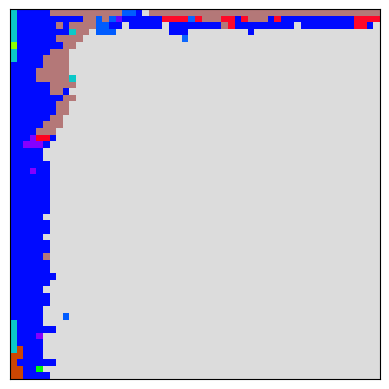

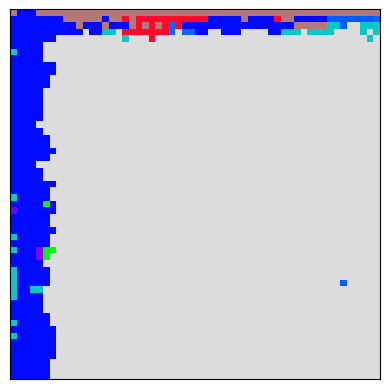

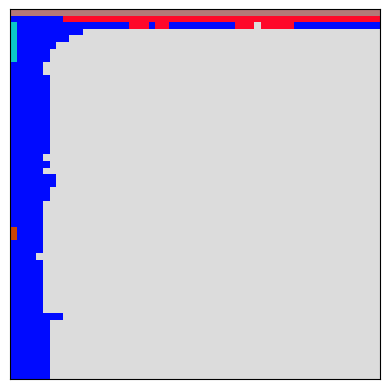

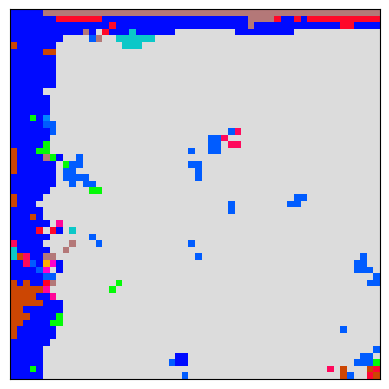

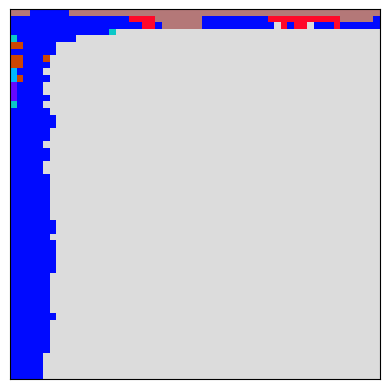

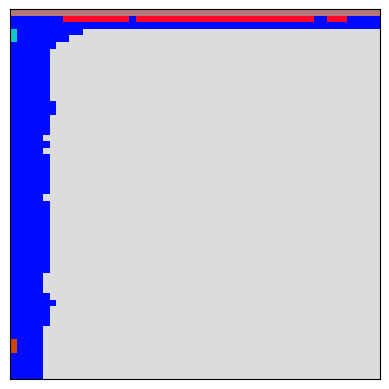

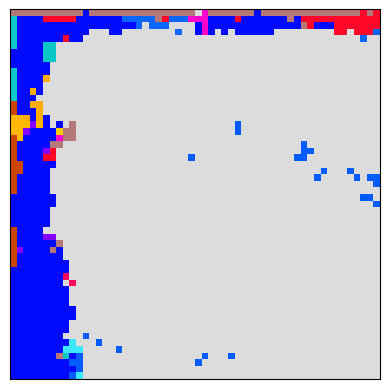

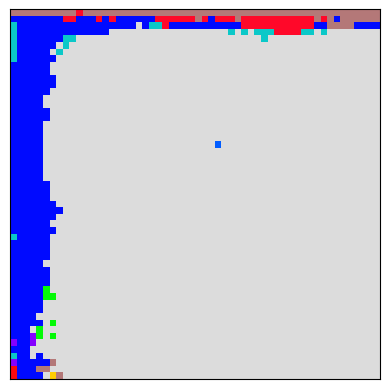

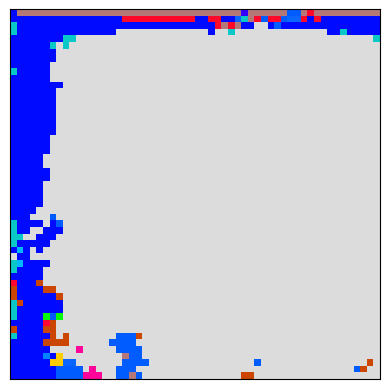

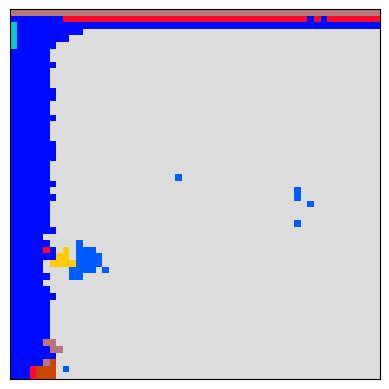

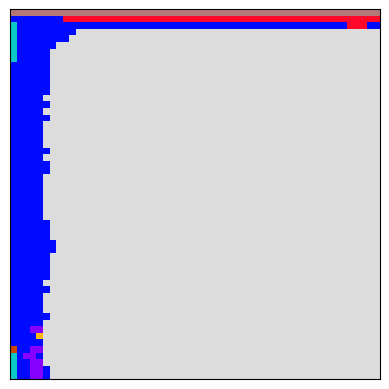

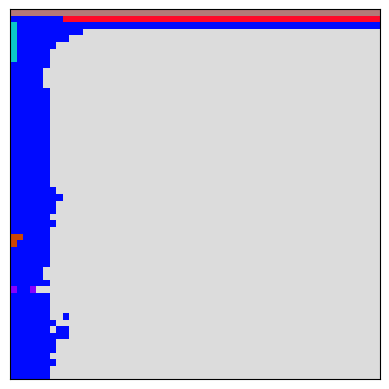

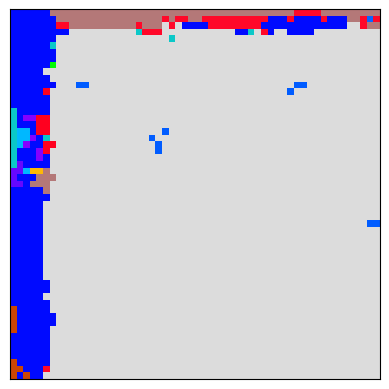

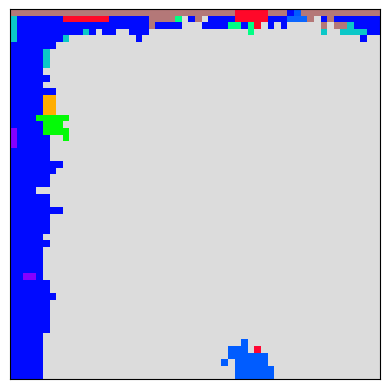

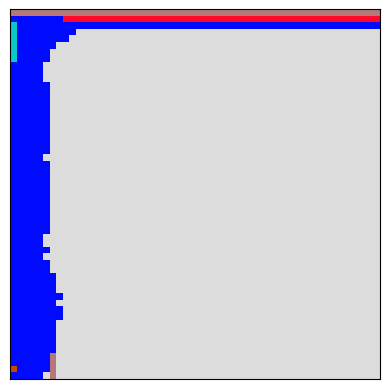

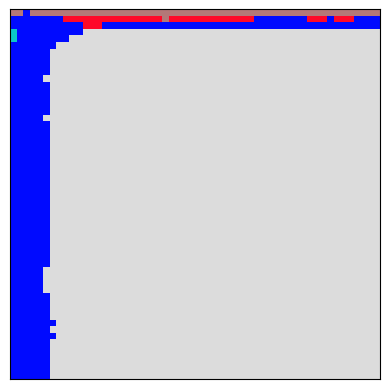

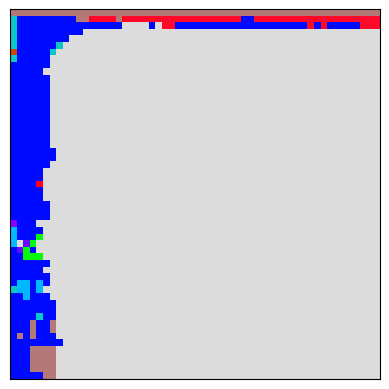

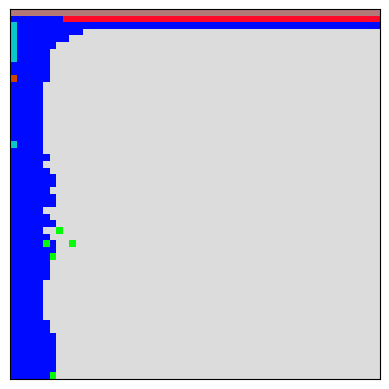

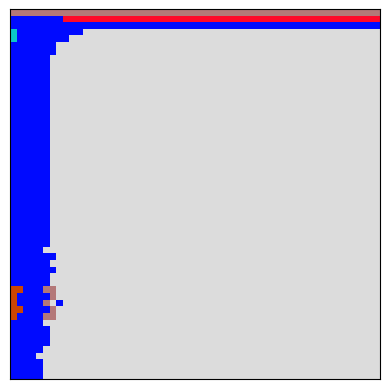

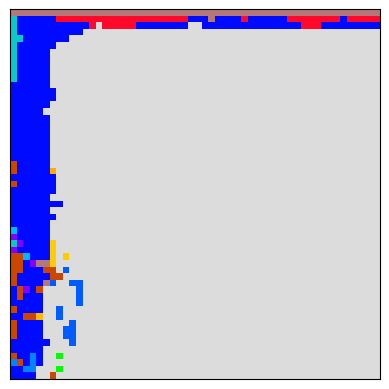

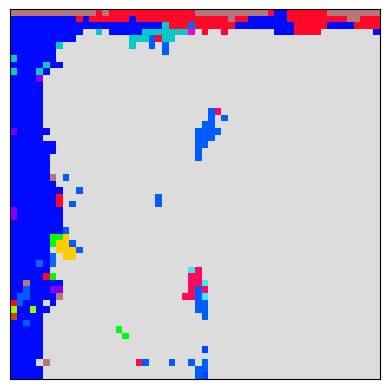

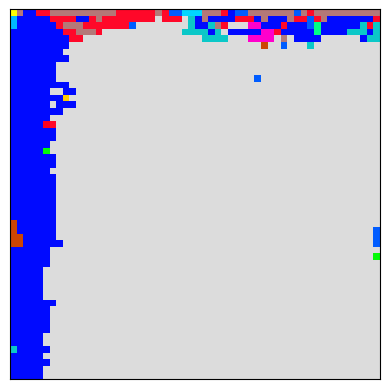

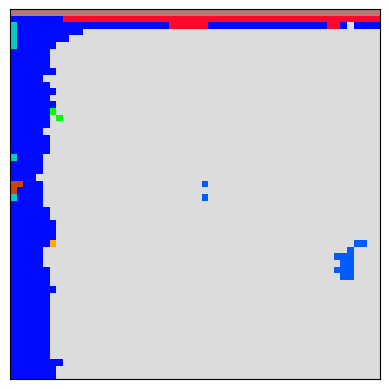

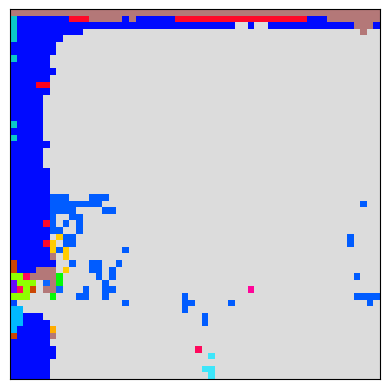

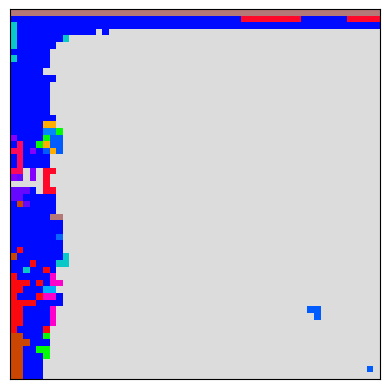

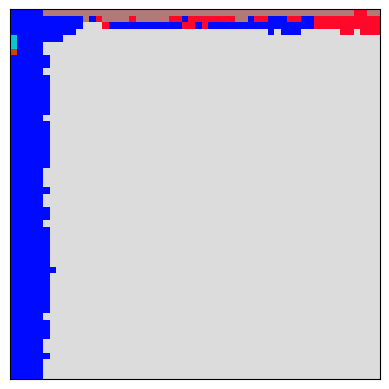

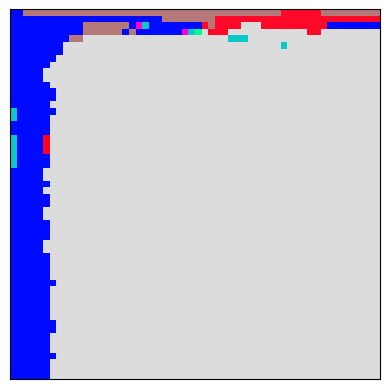

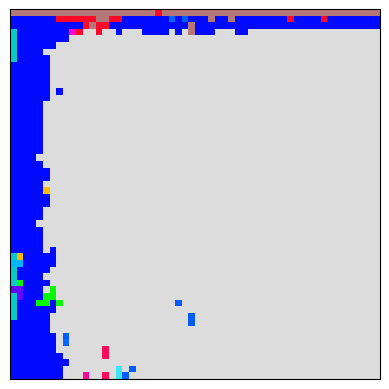

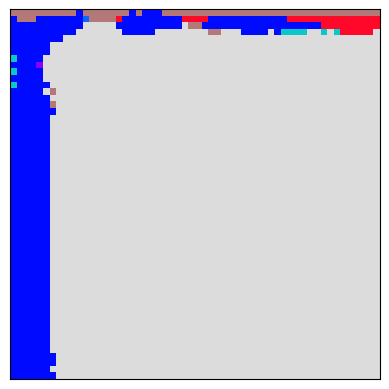

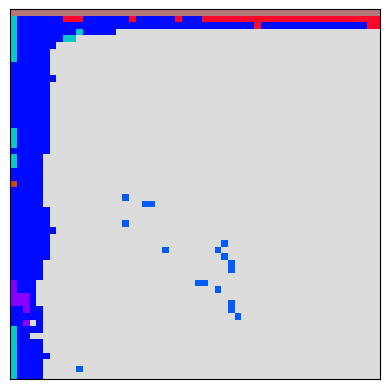

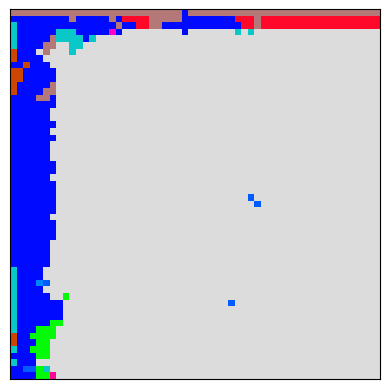

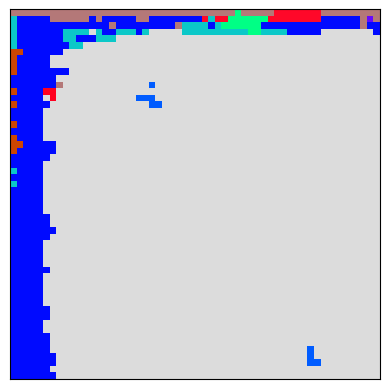

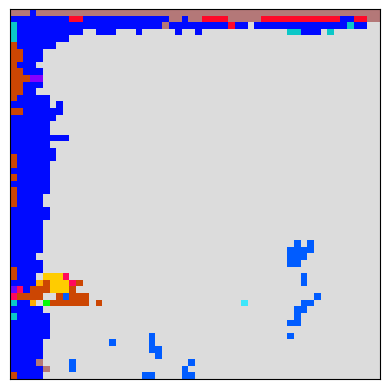

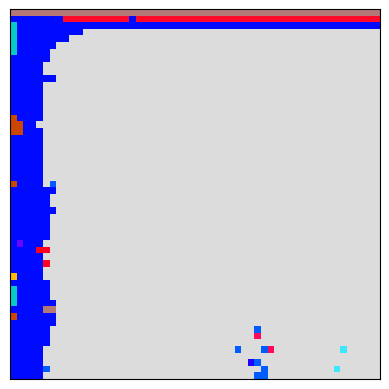

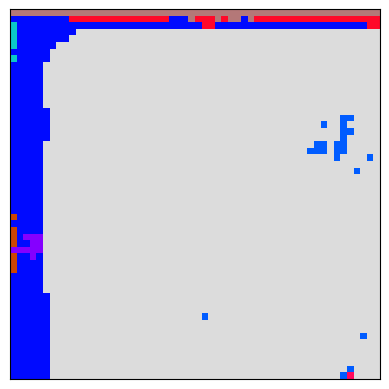

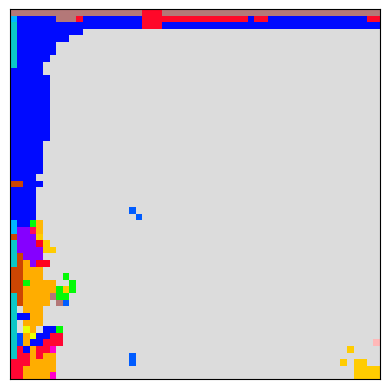

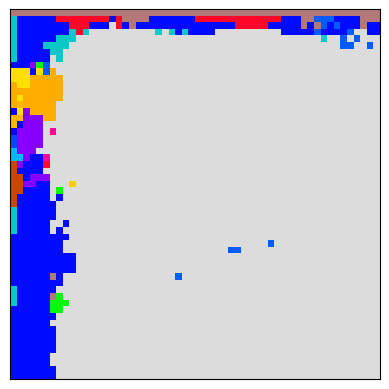

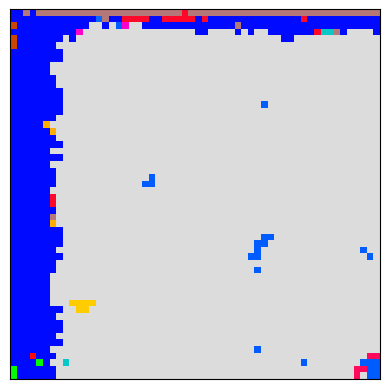

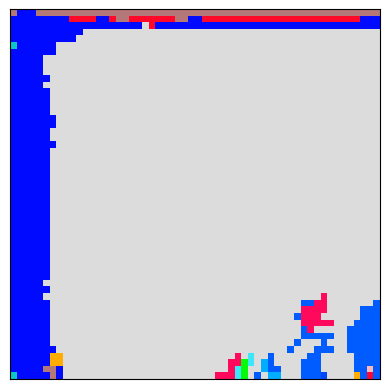

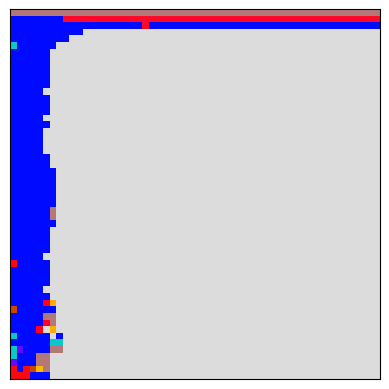

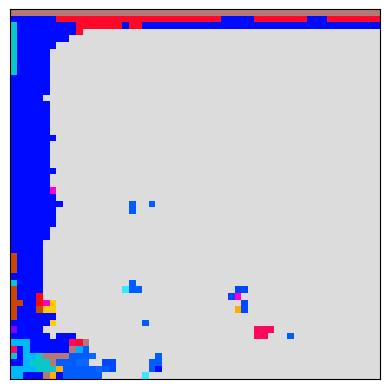

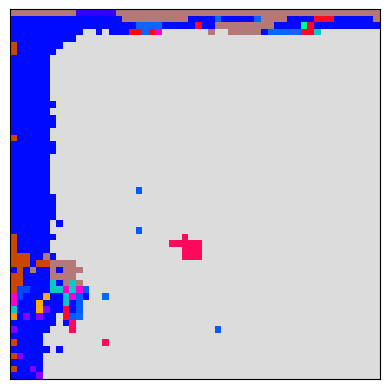

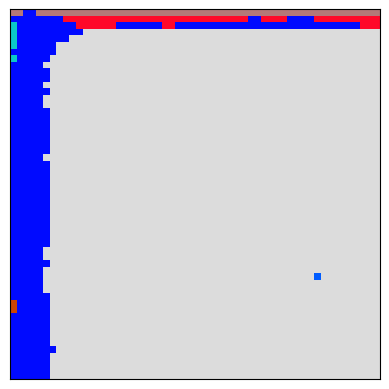

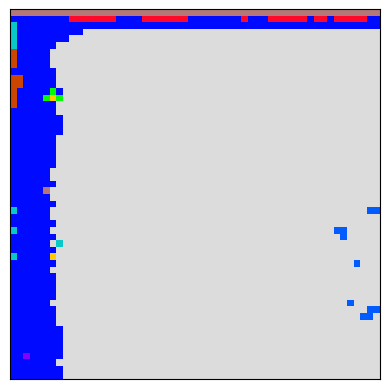

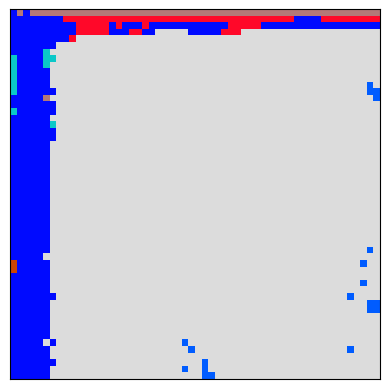

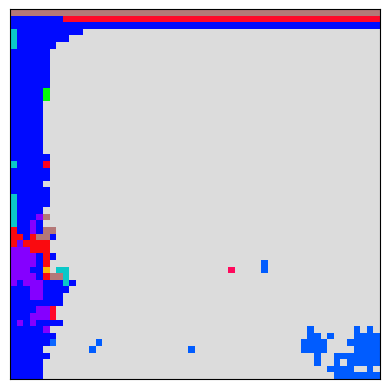

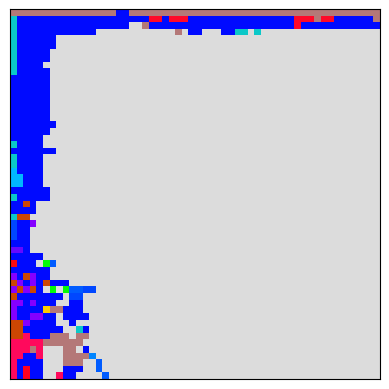

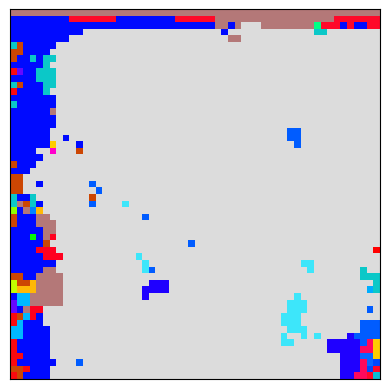

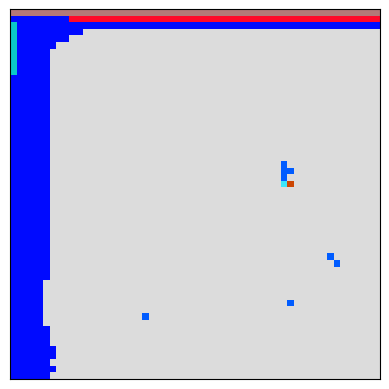

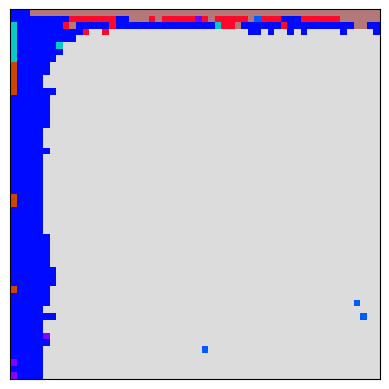

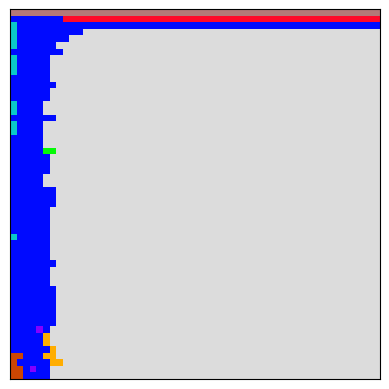

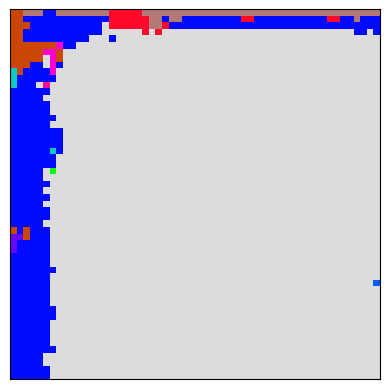

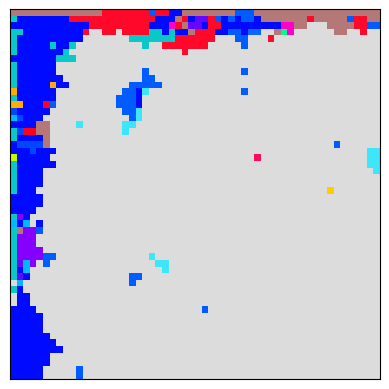

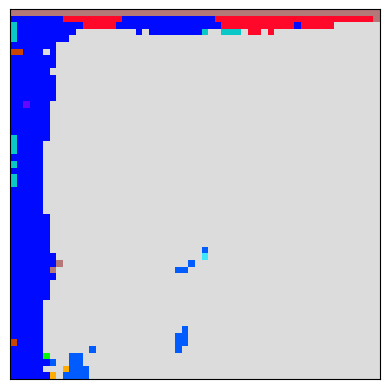

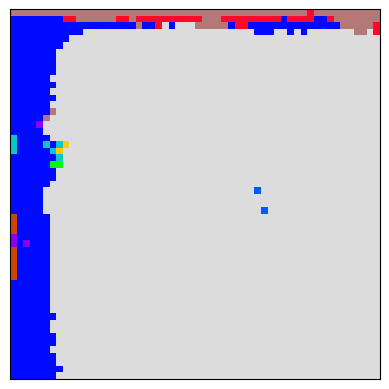

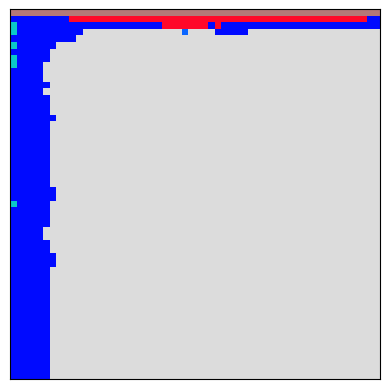

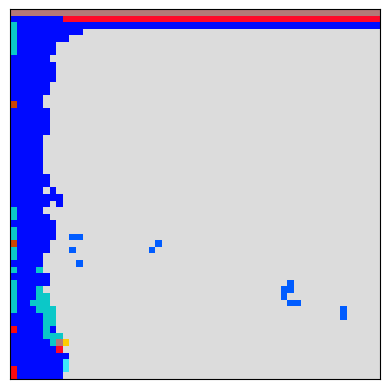

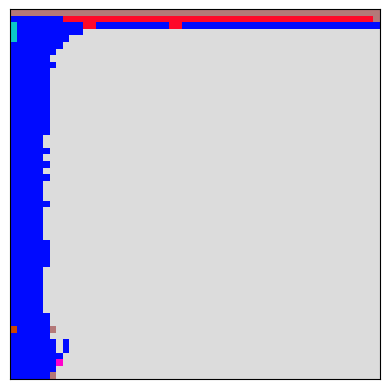

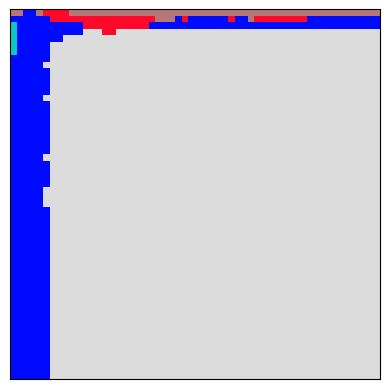

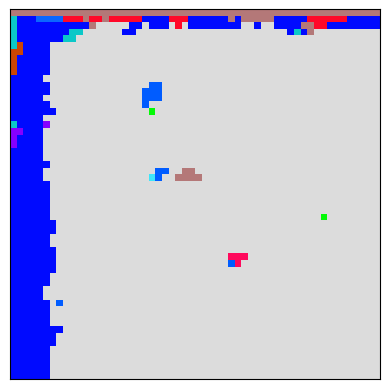

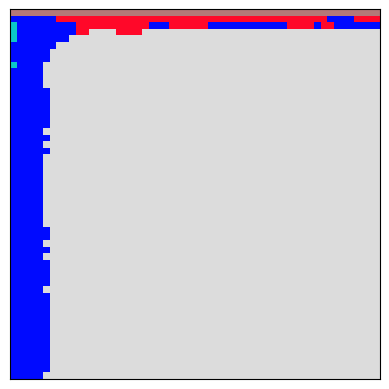

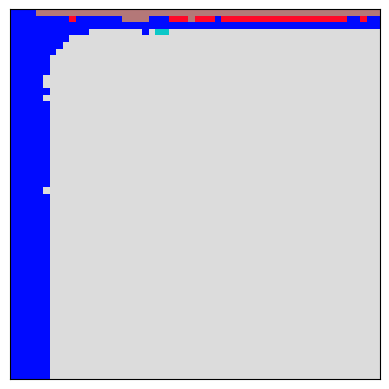

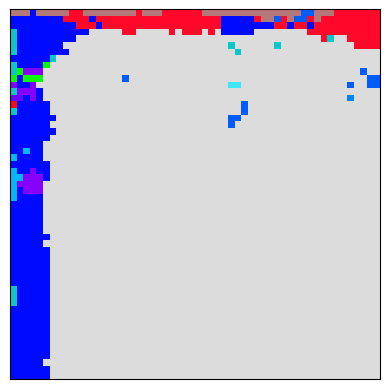

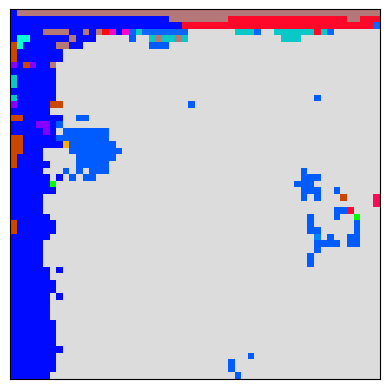

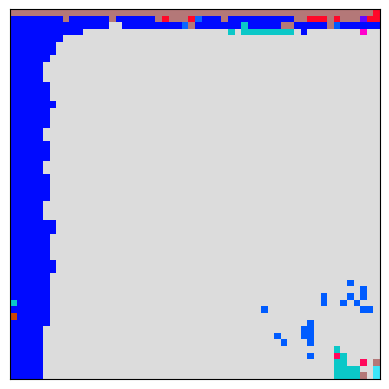

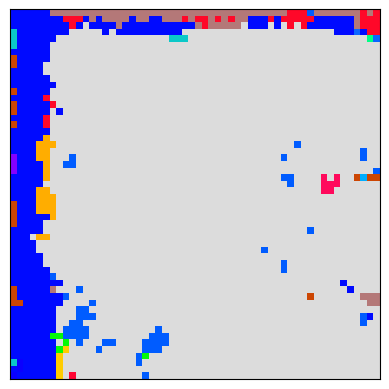

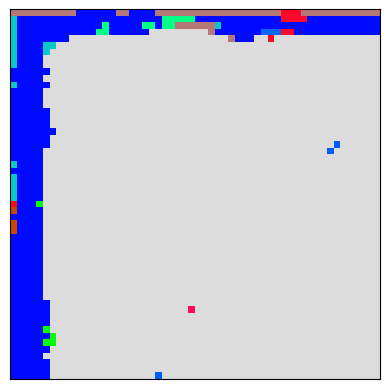

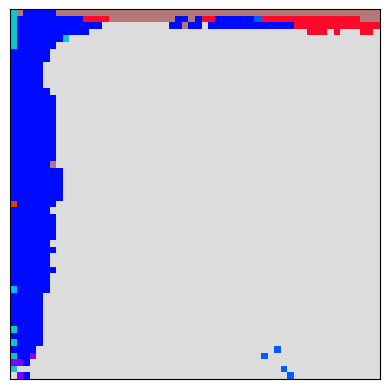

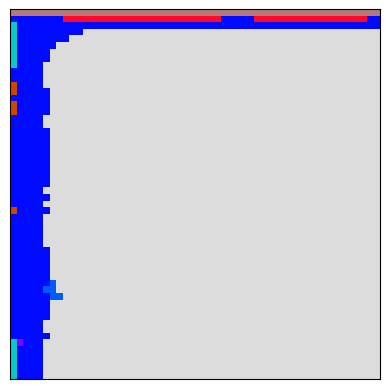

In [17]:
from semseg.datasets import *

#model = model.to(device)
predictions = []
start = time.time()
#print('test')
# Use torch.no_grad() to disable gradient computation during testing
with torch.no_grad():

    for images, labels in train_loader:
        # Move the data to the desired device
        #print(images.shape)
        images = images.permute(0,3,1,2).to(device)
        #images = images.permute(2,0,1).to(device)
        #images = images [None, :, :, :]
        #print(images.shape)
        
        #print(images.shape)
        #labels = labels.to(device)

        # Forward pass to get the predictions
        with torch.inference_mode():
          prediction = model(images)
        #print(prediction)
        prediction = prediction.softmax(1).argmax(1).to(int)
        #prediction = prediction.round().to(int)
        #print(prediction.shape)
        un = prediction.unique()
        #print(un)
        palette = eval('ADE20K').PALETTE.to(device)
        prediction_map = palette[prediction].squeeze().to(torch.uint8)
        #print(type(prediction_map))
        show_image(prediction_map)
        predictions.append(prediction_map)
        
end = time.time()
print(end-start)